In [21]:
import re
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn import tree 
from sklearn import preprocessing
import plotly.express as px

In [22]:
Clean_DF = pd.read_csv('Steam_Clean_Data.csv')
Train_reco = pd.read_csv('Train_reco.csv')
Test_reco = pd.read_csv('Test_reco.csv')
Train_auth = pd.read_csv('Train_auth.csv')
Test_auth = pd.read_csv('Test_auth.csv')

In [23]:
Tfidf_reco=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_reco = Tfidf_reco.fit_transform(Train_reco['review'])

In [24]:
Train_DTM_DF_reco=pd.DataFrame(Train_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())

In [25]:
## Instantiate
MyDT_reco=DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            class_weight=None)

MyDT_reco.fit(Train_DTM_DF_reco, Train_reco['recommendation'])

feature_names = Train_DTM_DF_reco.columns
class_names = Train_reco['recommendation'].unique()

In [26]:
'''fig = plt.figure(figsize=(30, 30))
MyTree1 = tree.plot_tree(MyDT1, impurity=True, rounded=True,
                         feature_names = feature_names, 
                         class_names = class_names, 
                         filled=True, fontsize=13)'''

'fig = plt.figure(figsize=(30, 30))\nMyTree1 = tree.plot_tree(MyDT1, impurity=True, rounded=True,\n                         feature_names = feature_names, \n                         class_names = class_names, \n                         filled=True, fontsize=13)'

In [27]:
Test_DTM_reco = Tfidf_reco.transform(Test_reco['review'])
Test_DTM_DF_reco=pd.DataFrame(Test_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
DT_pred_reco=MyDT_reco.predict(Test_DTM_DF_reco)


The confusion matrix is:
[[11763 15858]
 [ 3940 52255]]


0.7637921160637587

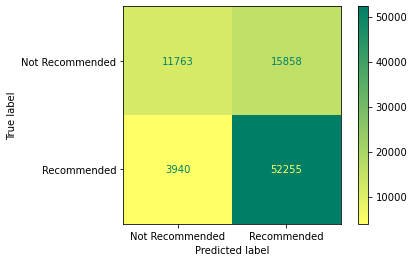

In [28]:
bn_matrix = confusion_matrix(Test_reco['recommendation'], DT_pred_reco)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(MyDT_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'summer_r')
#plt.savefig('MyTree1_cm.png')
accuracy_score(Test_reco['recommendation'], DT_pred_reco)